## Analysis of results

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

In [2]:
all_results = []
n_buildings = [2,4,8]
for n in n_buildings:
    results = {}
    models = ['mpc','sac','ppo']
    for model in models:
        kpis = {
            # 'all_time_peak_average': 'Average peak cost.',
            'carbon_emissions_total': 'Rolling sum of carbon emissions.', 
            'cost_total': 'Rolling sum of electricity monetary cost.',
            'electricity_consumption_total': 'Rolling sum of positive electricity consumption.',
            'daily_one_minus_load_factor_average': 'A measure of load variability / peakiness (daily average).', 
            'daily_peak_average': 'Average daily peak cost.',
            # 'monthly_one_minus_load_factor_average': 'A measure of load variability / peakiness (monthly average).',
            'ramping_average': 'Average rolling sum of absolute difference in net electric consumption between consecutive time steps',
            # 'zero_net_energy': 'Rolling sum of net electricity consumption'
        }
        result = pd.read_csv(f'results/results_{model}_2022_centralized/{n}_buildings/performance_kpis.csv')
        result = result[result['cost_function'].isin(kpis.keys())].reset_index(drop=True)
        result = result[result['level']=='district'].reset_index(drop=True)
        result = result.rename(columns={'value': model})
        results[model] = result
    agg_results = results['mpc'][['cost_function', 'mpc']].merge(results['ppo'][['cost_function', 'ppo']], on='cost_function').merge(results['sac'][['cost_function', 'sac']], on='cost_function')
    agg_results['best'] = agg_results[['mpc', 'ppo', 'sac']].idxmin(axis=1)
    agg_results['n_buildings'] = n
    agg_results = agg_results.round(2)
    agg_results = agg_results[['n_buildings', 'cost_function', 'mpc', 'ppo', 'sac', 'best']]
    all_results.append(agg_results)
all_results = pd.concat(all_results, ignore_index=True)

In [3]:
all_results

,n_buildings,cost_function,mpc,ppo,sac,best
0,2,carbon_emissions_total,1.00,0.97,0.94,sac
1,2,cost_total,0.99,0.93,0.89,sac
2,2,daily_one_minus_load_factor_average,1.00,0.99,0.99,ppo
3,2,daily_peak_average,1.18,0.97,0.96,sac
4,2,electricity_consumption_total,0.99,0.97,0.94,sac
5,2,ramping_average,1.41,1.12,1.07,sac
6,4,carbon_emissions_total,1.02,1.00,0.97,sac
7,4,cost_total,1.00,0.94,0.94,sac
8,4,daily_one_minus_load_factor_average,1.02,0.98,0.99,ppo
9,4,daily_peak_average,1.37,0.94,0.97,ppo


In [4]:
# Convert to long format for seaborn
df_long = all_results.melt(
    id_vars=['n_buildings', 'cost_function'],
    value_vars=['mpc', 'ppo', 'sac'],
    var_name='method',
    value_name='value'
)

# color transparency 
ALPHA = 0.6

# order of the cost functions
ordered_costs = [
    "cost_total",
    "electricity_consumption_total",
    "carbon_emissions_total",
    "daily_peak_average",
    "ramping_average",
    "daily_one_minus_load_factor_average"
]

### Line Plot of Method Performance Across Cost Functions and Building Counts

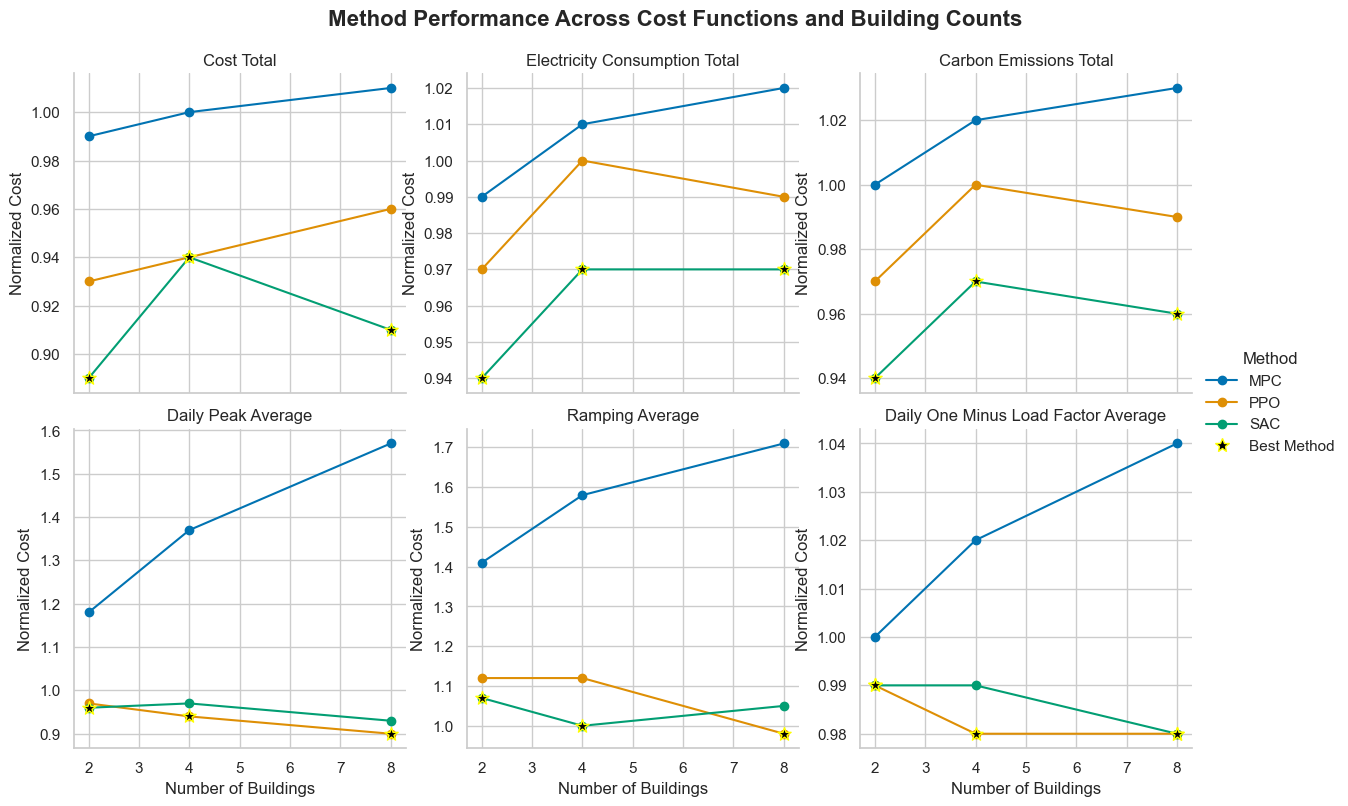

In [5]:
# Identify the best method per group (min value)
df_long['is_best'] = df_long.groupby(['n_buildings', 'cost_function'])['value'].transform('min') == df_long['value']

# Set up colorblind-friendly palette
palette = sns.color_palette("colorblind")

# specify the order of cost functions 
df_long['cost_function'] = pd.Categorical(
    df_long['cost_function'],
    categories=ordered_costs,
    ordered=True
)

# Plot
sns.set(style="whitegrid")
g = sns.FacetGrid(
    df_long, col="cost_function",
    col_order = ordered_costs,
    col_wrap=3, height=4, sharey=False  # normalize y-limits
)

# Add lines with markers and highlight best points
def plot_func(data, **kwargs):
    for method in ['mpc', 'ppo', 'sac']:
        subset = data[data['method'] == method]
        plt.plot(subset['n_buildings'], subset['value'],
                 marker='o', label=method.upper(),
                 color=palette[['mpc', 'ppo', 'sac'].index(method)])
        
        # Highlight best points
        best_points = subset[subset['is_best']]
        plt.scatter(best_points['n_buildings'], best_points['value'],
                    color='black', edgecolor='yellow', s=100, zorder=10, marker='*')

g.map_dataframe(plot_func)

# Improve axis labels
for ax in g.axes.flat:
    ax.set_ylabel("Normalized Cost")
    ax.set_xlabel("Number of Buildings")

# Improve facet titles
for ax in g.axes.flat:
    title = ax.get_title().replace("cost_function = ", "").replace("_", " ").title()
    ax.set_title(title)

# Add legend and title
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Method Performance Across Cost Functions and Building Counts", fontsize=16, fontweight='bold')

# Custom "Best Method" star legend entry
star_best = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                          markersize=10, markeredgecolor='yellow', label='Best Method')

# Get existing handles and labels from the first axis
handles, labels = g.axes[0].get_legend_handles_labels()

# Append the star marker
handles.append(star_best)
labels.append('Best Method')

# Add the updated legend
g.add_legend(handles=handles, labels=labels, title='Method')

plt.show()


### Bar Plot (Grouped by Cost Function)

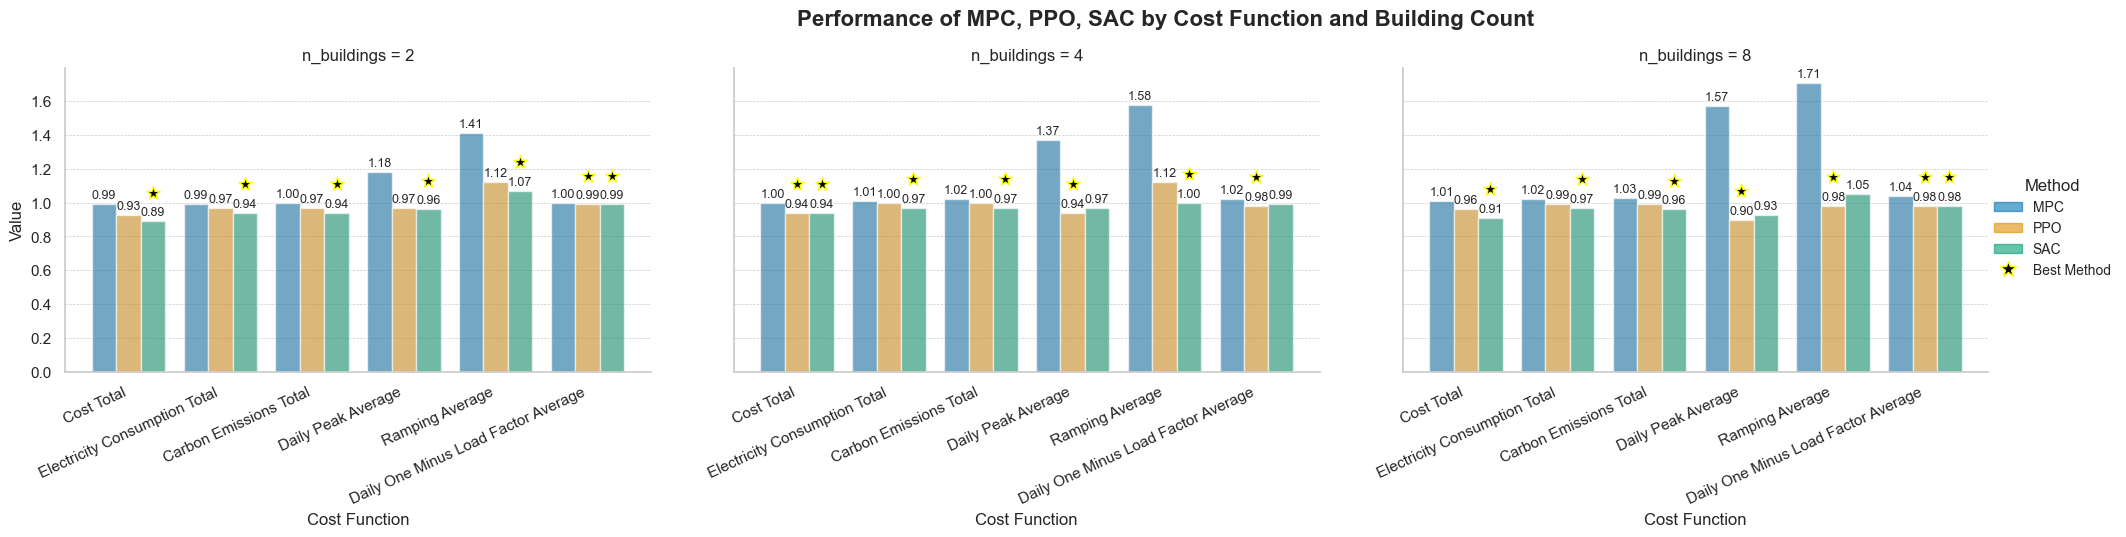

In [6]:
# Mark best (with warning fix)
df_long["is_best"] = df_long.groupby(
    ["cost_function", "n_buildings"], observed=True
)["value"].transform("min") == df_long["value"]

# Reorder cost_function by average performance (with warning fix)
avg_cost = df_long.groupby("cost_function", observed=True)["value"].mean().sort_values()
df_long["cost_function"] = pd.Categorical(df_long["cost_function"], 
                                          categories=ordered_costs, 
                                          ordered=True)

# Set color palette
palette = sns.color_palette("colorblind")
method_order = ["mpc", "ppo", "sac"]
color_map = dict(zip(method_order, palette))

# Plot with col-wise layout (horizontal stacking)
sns.set(style="whitegrid")
g = sns.catplot(
    data=df_long,
    x="cost_function", y="value", hue="method",
    col="n_buildings", kind="bar",
    hue_order=method_order,
    palette=color_map,
    height=4.2, aspect=1.8,
    sharey=True,
    width=0.8,
    alpha=ALPHA
)
g.set_axis_labels("Cost Function", "Value")

# Adjust spacing
g.fig.subplots_adjust(right=0.85, hspace=0.3, top=0.88)
g.fig.suptitle("Performance of MPC, PPO, SAC by Cost Function and Building Count", fontsize=16, y=1.02, fontweight='bold')

# Clean up ticks, titles, annotate values and stars
for ax, n in zip(g.axes.flat, [2, 4, 8]):
    # Set clearer subplot titles
    ax.set_title(f"n_buildings = {n}", fontsize=12)

    # Format x-axis labels
    xticks = ax.get_xticks()
    xticklabels = [tick.get_text().replace('_', ' ').title() for tick in ax.get_xticklabels()]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=25, ha='right')

    # Add grid lines
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5)

    # Annotate value labels and stars
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            x = bar.get_x() + bar.get_width() / 2
            ax.text(x, 
                    height + 0.015, 
                    f"{height:.2f}", 
                    ha='center', 
                    va='bottom', 
                    fontsize=9)

    for i, tick in enumerate(ax.get_xticks()):
        cost_func = ordered_costs[i]
        for method in method_order:
            subset = df_long[
                (df_long["cost_function"] == cost_func) &
                (df_long["n_buildings"] == n) &
                (df_long["method"] == method)
            ]
            if not subset.empty and subset.iloc[0]["is_best"]:
                bar = ax.containers[method_order.index(method)][i]
                ax.scatter(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 0.17,
                    marker='*', s=100, zorder=10,
                    facecolor='black', edgecolor='yellow'
                )

# Add custom legend on the right
method_handles = [
    mpatches.Patch(color=color_map[m], label=m.upper(), alpha=ALPHA) for m in method_order
]
star_legend = mlines.Line2D(
    [], [], marker='*', linestyle='None',
    markersize=12,
    markerfacecolor='black',
    markeredgecolor='yellow',
    label='Best Method'
)

g._legend.remove()
legend = g.fig.legend(
    handles=method_handles + [star_legend],
    title="Method",
    loc='center left',
    bbox_to_anchor=(0.85, 0.5),
    borderaxespad=0,
    fontsize='small',
    title_fontsize='medium'
)
legend.get_frame().set_visible(False)
plt.show()

### Heatmap of Best Method Counts

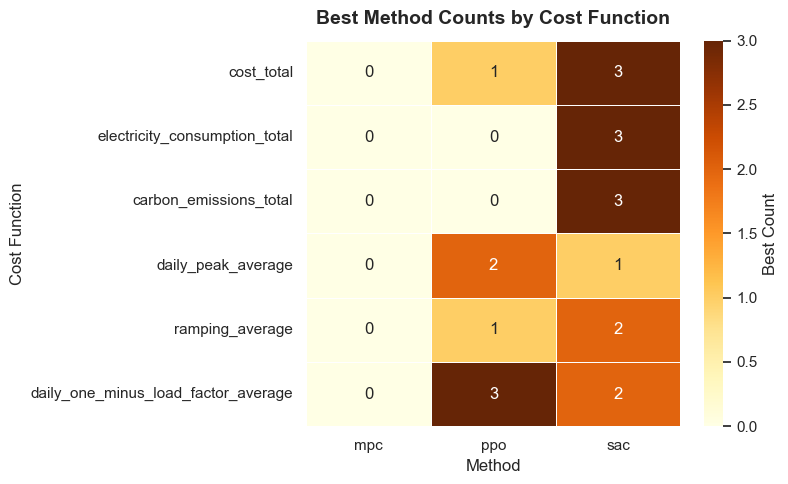

In [7]:
# Count how often each method is best for each cost function
best_counts = df_long[df_long['is_best']].groupby(
    ['cost_function', 'method'], observed=True
).size().unstack(fill_value=0)

# Reindex to include all methods
best_counts = best_counts.reindex(columns=["mpc", "ppo", "sac"], fill_value=0)

# Sort by total wins
best_counts['total'] = best_counts.sum(axis=1)
best_counts = best_counts.sort_values('total', ascending=False).drop(columns='total')
best_counts = best_counts.reindex(ordered_costs)

# Plot
plt.figure(figsize=(8, 5))
sns.heatmap(
    best_counts,
    annot=True, fmt="d",
    cmap="YlOrBr",
    linewidths=0.5,
    cbar_kws={'label': 'Best Count'}
)
plt.title("Best Method Counts by Cost Function", fontsize=14, pad=12, fontweight='bold')
plt.ylabel("Cost Function", fontsize=12)
plt.xlabel("Method", fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

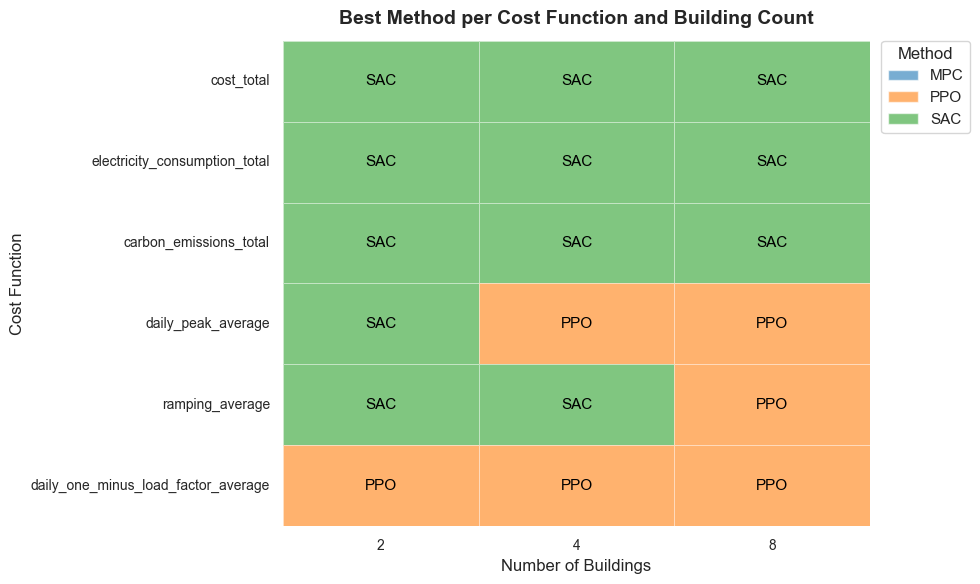

In [8]:
# Color palette
method_to_code = {"mpc": 0, "ppo": 1, "sac": 2}
code_to_method = {v: k for k, v in method_to_code.items()}
method_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green

# Data prep
best_by_building = all_results.pivot(index="cost_function", columns="n_buildings", values="best")
best_by_building = best_by_building.reindex(ordered_costs)
method_matrix = best_by_building.map(lambda x: method_to_code.get(x, -1))  # -1 for missing

# Plot
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    method_matrix,
    cmap=ListedColormap(["#ff7f0e", "#1f77b4", "#2ca02c"]),
    annot=best_by_building.map(str.upper),  # show 'SAC', 'PPO', etc.
    fmt='',
    linewidths=0.5,
    linecolor='white',
    cbar=False,
    alpha=ALPHA,
    annot_kws={"fontsize": 11}
)
ax.grid(False)

# Improve annotation contrast
for text in ax.texts:
    method = text.get_text().lower()
    text.set_color("black")

# Axis labels and title
plt.title("Best Method per Cost Function and Building Count", fontsize=14, pad=12, fontweight='bold')
plt.xlabel("Number of Buildings", fontsize=12)
plt.ylabel("Cost Function", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Legend
legend_elements = [
    Patch(facecolor=color, label=label.upper(), alpha=ALPHA)
    for label, color in zip(method_to_code.keys(), method_colors)
]
plt.legend(
    handles=legend_elements,
    title="Method",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0
)

plt.tight_layout()
plt.show()


### Radar chart for each method

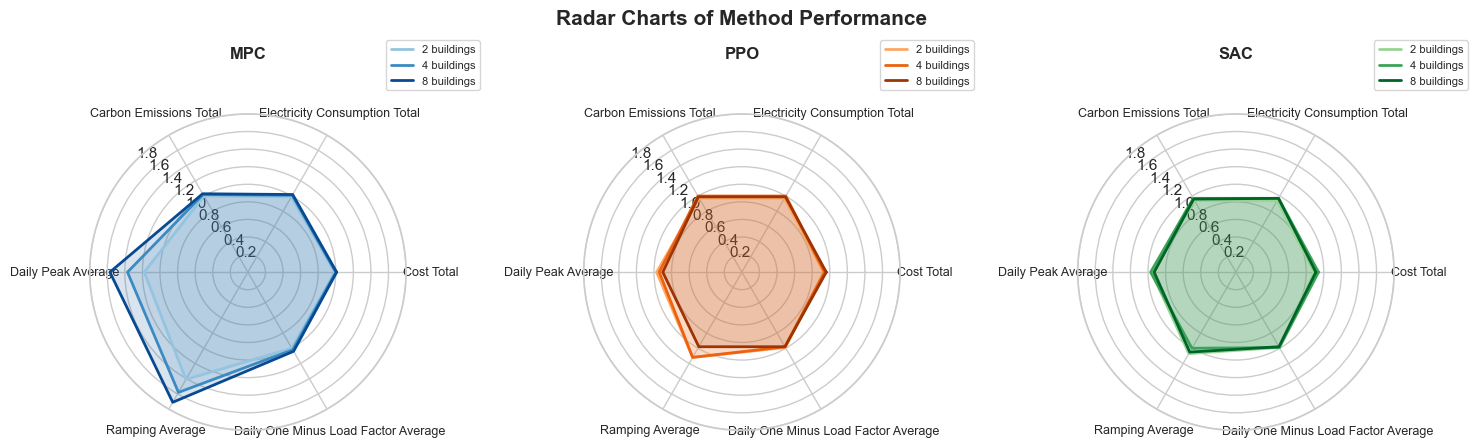

In [12]:
# Pivot the data
radar_data = df_long.pivot_table(
    index=["method", "n_buildings"],
    columns="cost_function",
    values="value",
    observed=True
)

# Reorder the columns by desired cost function order
radar_data = radar_data[ordered_costs]

# Sort the index
radar_data = radar_data.sort_index()

colors = {
    'mpc': mpl.colormaps['Blues'],
    'ppo': mpl.colormaps['Oranges'],
    'sac': mpl.colormaps['Greens']
}

building_sizes = [2, 4, 8]
intensity = np.linspace(0.4, 0.9, len(building_sizes))  # Lighter to darker

# Assume `radar_data` is already set: MultiIndex (method, n_buildings) x cost_function
cost_functions = list(radar_data.columns)
n_costs = len(cost_functions)
angles = np.linspace(0, 2 * np.pi, n_costs, endpoint=False).tolist() + [0]

# Plotting function
def plot_radar(df, method, ax):
    for i, n in enumerate(building_sizes):
        values = df.loc[(method, n)].tolist()
        values += values[:1]
        color = colors[method](intensity[i])
        ax.plot(angles, values, label=f'{n} buildings', color=color, linewidth=2)
        ax.fill(angles, values, color=color, alpha=0.15)
    
    # Axis aesthetics
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(
        [c.replace('_', ' ').title() for c in cost_functions],
        fontsize=9,
        ha='center',
        zorder=100
    )
    ax.tick_params(pad=5)
    ax.set_rlabel_position(135)
    ax.set_ylim(0, 1.8)
    ax.set_title(f"{method.upper()}", y=1.15, fontsize=12, fontweight='bold')

# Plot setup
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(15, 5))
for i, method in enumerate(['mpc', 'ppo', 'sac']):
    plot_radar(radar_data, method, axs[i])
    axs[i].legend(loc='upper right', bbox_to_anchor=(1.25, 1.25), fontsize=8)

plt.suptitle("Radar Charts of Method Performance", fontsize=15, y=0.93, fontweight='bold')
plt.tight_layout()
plt.show()